In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import io


In [ ]:
df = pd.read_csv('/content/llm_scoring_results_combined.csv')

In [ ]:
def process_raw_data(df):

    # Convert score to numeric
    df['score'] = pd.to_numeric(df['score'], errors='coerce')

    # Extract iteration from question_id using regex
    df['iteration'] = df['question_id'].str.extract(r'_(\d+)$', expand=False).astype(int)

    # Extract question number
    df['question_num'] = df['question_id'].str.extract(r'q(\d+)_', expand=False).astype(int)

    return df


In [ ]:
df = process_raw_data(df)

In [ ]:
df.head()

,question_id,llm,score,iteration,question_num
0,q10_10,Claude,5,10,10
1,q10_10,GPT,4,10,10
2,q10_10,Mistral,3,10,10
3,q10_10,Cohere,3,10,10
4,q10_10,Deepseek,3,10,10


In [ ]:

# Define a custom colour palette for the models
model_palette = {
    "Claude": "#1f77b4",    # Blue
    "Cohere": "#ff7f0e",    # Orange
    "GPT": "#2ca02c",       # Green
    "Mistral": "#d62728",   # Red
    "Deepseek": "#9467bd"   # Purple
}


In [ ]:

def plot_score_by_iteration(df):
    """Plot scores by iteration for each LLM"""
    plt.figure(figsize=(12, 6))

    # Calculate average score by iteration and LLM
    avg_by_iter = df.groupby(['iteration', 'llm'])['score'].mean().reset_index()

    # Create line plot
    sns.lineplot(data=avg_by_iter, x='iteration', y='score', hue='llm', marker='o', palette=model_palette)

    #plt.title('LLM Scores by Iteration', fontsize=15)
    plt.xlabel('Iteration Number', fontsize=12)
    plt.ylabel('Average Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='LLM Model')

    # Set y-axis limits to emphasize differences
    y_min = max(0, avg_by_iter['score'].min() - 0.5)
    y_max = min(5, avg_by_iter['score'].max() + 0.5)
    plt.ylim(y_min, y_max)

    plt.tight_layout()
    plt.savefig('llm_scores_by_iteration.png')

    plt.savefig("reinforcement_1.png", dpi=300, bbox_inches='tight')

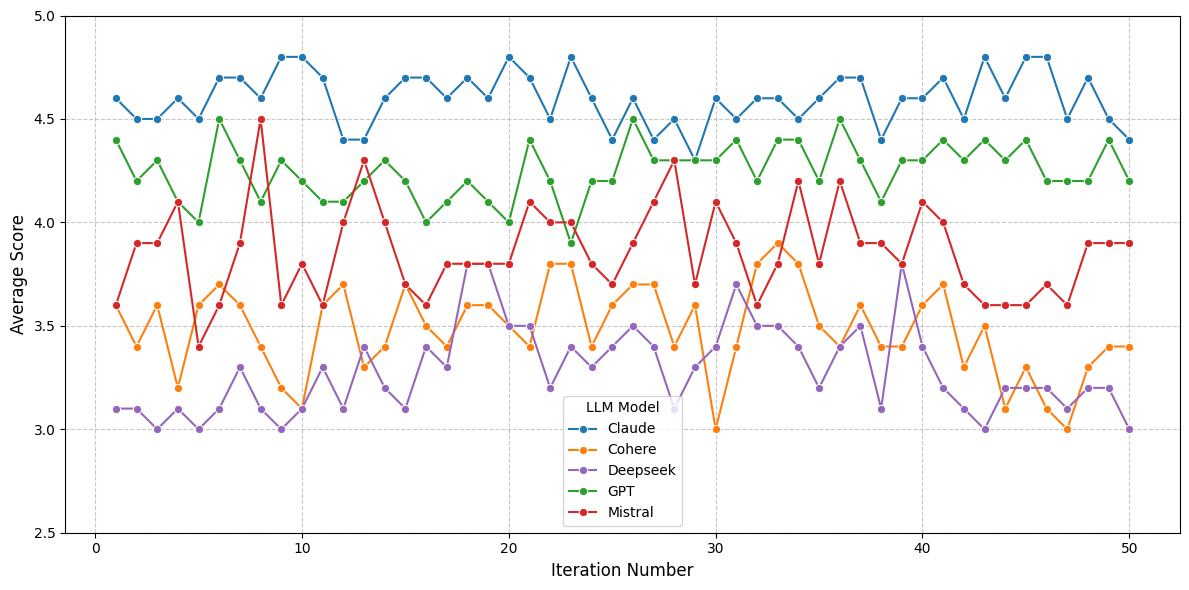

In [ ]:
#sanity check
plot_score_by_iteration(df)

In [ ]:
def plot_average_scores_by_llm(df):
    """Plot average scores by LLM model"""
    plt.figure(figsize=(10, 6))

    # Calculate average scores by LLM
    avg_scores = df.groupby('llm')['score'].mean().sort_values(ascending=False).reset_index()

    # Bar plot
    sns.barplot(x='llm', y='score', data=avg_scores, palette=model_palette)

    #plt.title('Average Score by LLM Model', fontsize=15)
    plt.xlabel('LLM Model', fontsize=15)
    plt.ylabel('Average Score', fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    # Add value labels on bars
    for i, v in enumerate(avg_scores['score']):
        plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

    # Set y-axis limits to emphasize differences
    plt.ylim(0, 5.5)

    plt.tight_layout()
    plt.savefig('average_scores_by_llm.png')

    plt.savefig("reinforcement_2.png", dpi=300, bbox_inches='tight')

<ipython-input-13-ccdd8bf0b0b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='llm', y='score', data=avg_scores, palette=model_palette)


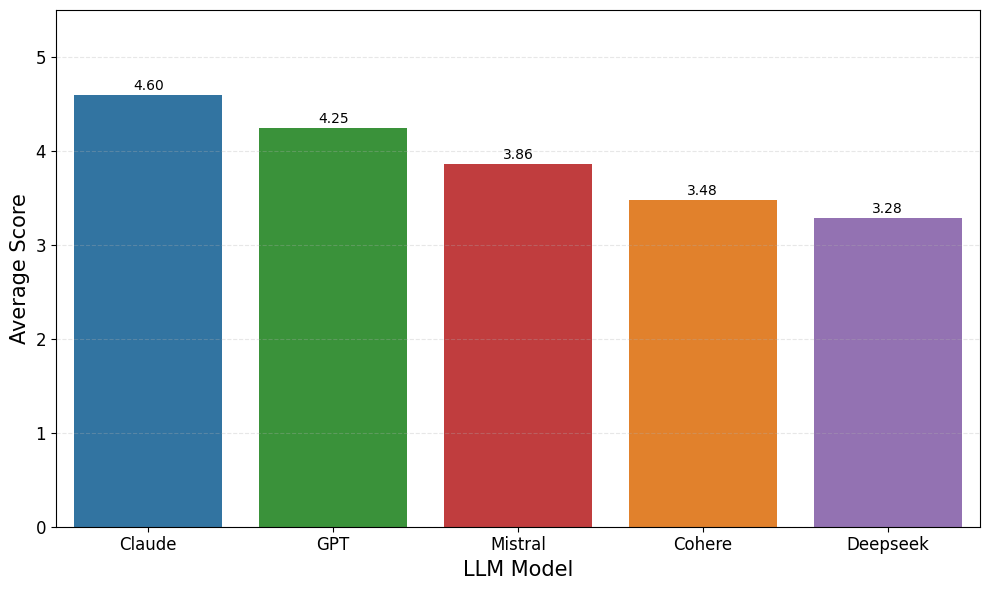

In [ ]:
#sanity checks
plot_average_scores_by_llm(df)


In [ ]:
def plot_heatmap_by_iteration_llm(df):
    """Create heatmap of scores by LLM and iteration"""
    # Create pivot table for heatmap
    pivot = df.pivot_table(index='llm', columns='iteration', values='score', aggfunc='mean')

    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot, annot=False, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Score'})

    plt.title('Score Heatmap by LLM and Iteration', fontsize=15)
    plt.ylabel('LLM Model', fontsize=12)
    plt.xlabel('Iteration Number', fontsize=12)

    plt.tight_layout()
    plt.savefig('score_heatmap.png')
    plt.show()

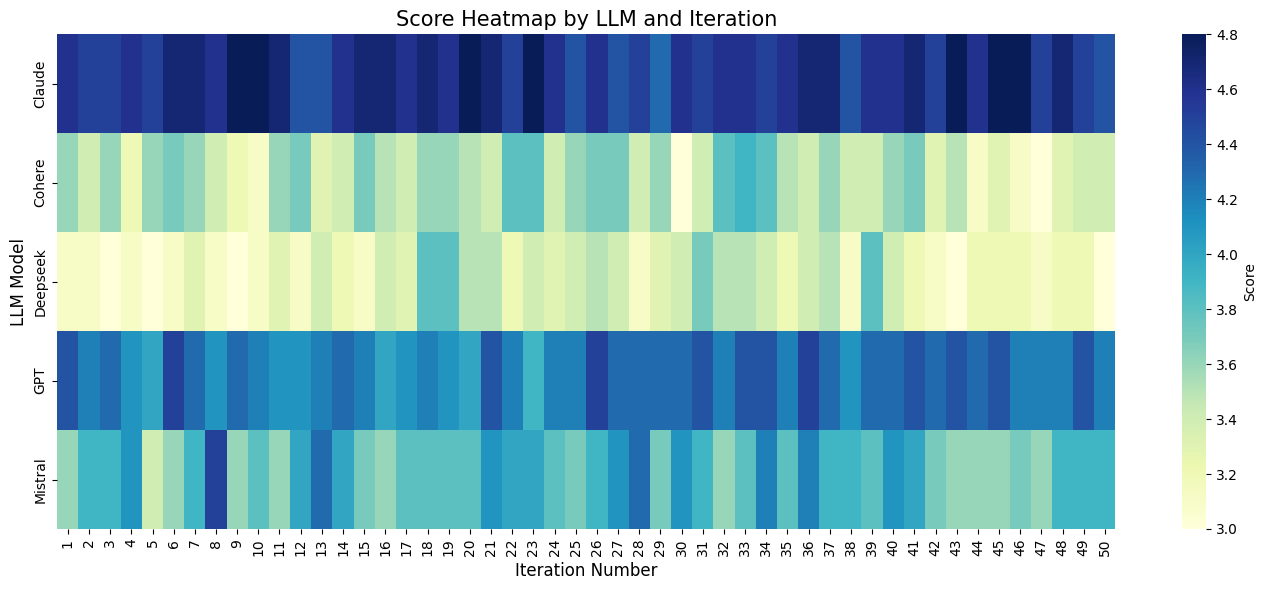

In [ ]:
#sanity checks
plot_heatmap_by_iteration_llm(df)

In [ ]:
def analyze_score_degradation(df):
    """Analyze if scores degrade over iterations using regression"""
    plt.figure(figsize=(15, 10))

    models = df['llm'].unique()

    # Track results for summary
    results = []

    for i, model in enumerate(models):
        model_data = df[df['llm'] == model]

        # Group by iteration to get mean scores
        avg_by_iter = model_data.groupby('iteration')['score'].mean().reset_index()

        iterations = avg_by_iter['iteration']
        scores = avg_by_iter['score']

        if len(iterations) > 1:  # Need at least 2 points for regression
            z = np.polyfit(iterations, scores, 1)
            p = np.poly1d(z)

            # Calculate R-squared
            residuals = scores - p(iterations)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((scores - np.mean(scores))**2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

            plt.subplot(len(models), 1, i+1)
            plt.scatter(iterations, scores, alpha=0.7,color = model_palette[model])
            plt.plot(sorted(iterations), p(sorted(iterations)), "r--")

            plt.title(f"{model}: Score = {z[0]:.4f} × Iteration + {z[1]:.2f} (R² = {r_squared:.2f})", fontsize = 12)
            plt.ylabel("Score", fontsize =15)
            plt.grid(True, alpha=0.3)

            if i == len(models) - 1:
                plt.xlabel("Iteration", fontsize =15)

            results.append({
                'Model': model,
                'Slope': z[0],
                'Intercept': z[1],
                'R_squared': r_squared
            })

    plt.tight_layout()
    plt.savefig('degradation_analysis.png')


    # Print regression results
    results_df = pd.DataFrame(results)
    print("\nRegression Analysis (Slope indicates rate of score change over iterations):")
    print(results_df.to_string(index=False))
    plt.savefig("reinforcement_3.png", dpi=300, bbox_inches='tight')

    return results_df


Regression Analysis (Slope indicates rate of score change over iterations):
   Model     Slope  Intercept  R_squared
  Claude -0.000307   4.607837   0.001199
     GPT  0.002660   4.180163   0.079681
 Mistral -0.000514   3.875102   0.001109
  Cohere -0.002958   3.555429   0.039611
Deepseek  0.001825   3.237469   0.015428


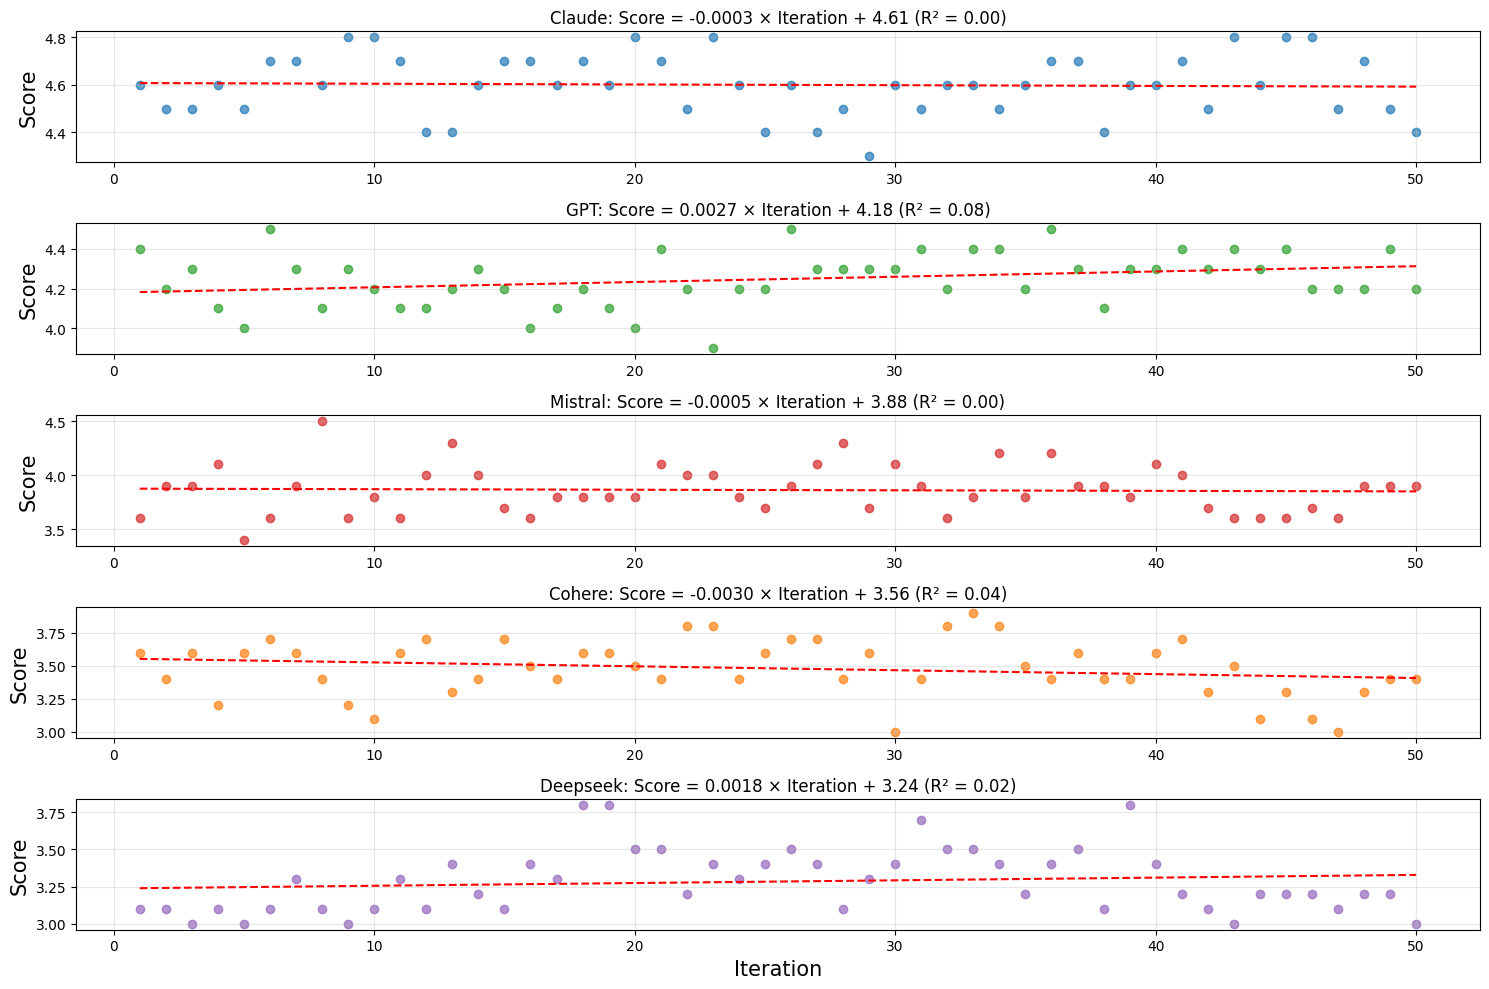

In [ ]:
#sanity checks
results = analyze_score_degradation(df)

In [ ]:
def perform_statistical_tests(df):
    """Perform various statistical tests on the data"""
    print("\nStatistical Analysis:")

    # Correlation between iteration and score for each model
    for model in df['llm'].unique():
        # Group by iteration first to get mean scores
        model_data = df[df['llm'] == model].groupby('iteration')['score'].mean().reset_index()
        correlation = model_data['iteration'].corr(model_data['score'])
        print(f"{model}: Correlation between iteration and score = {correlation:.4f}")

    # Average score for early vs late iterations
    median_iteration = df['iteration'].median()
    early = df[df['iteration'] <= median_iteration]['score'].mean()
    late = df[df['iteration'] > median_iteration]['score'].mean()
    print(f"\nAverage score for early iterations (≤{median_iteration}): {early:.2f}")
    print(f"Average score for late iterations (>{median_iteration}): {late:.2f}")
    print(f"Difference (late - early): {late - early:.2f}")

    # ANOVA to test if there are significant differences among LLMs
    from scipy import stats

    # Group data by LLM
    llm_groups = [df[df['llm'] == llm]['score'].values for llm in df['llm'].unique()]
    f_val, p_val = stats.f_oneway(*llm_groups)
    print(f"\nANOVA test for differences among LLMs: F={f_val:.2f}, p={p_val:.4f}")
    if p_val < 0.05:
        print("There are statistically significant differences among LLM scores.")
    else:
        print("No statistically significant differences detected among LLM scores.")

In [ ]:
#sanity checka
perform_statistical_tests(df)


Statistical Analysis:
Claude: Correlation between iteration and score = -0.0346
GPT: Correlation between iteration and score = 0.2823
Mistral: Correlation between iteration and score = -0.0333
Cohere: Correlation between iteration and score = -0.1990
Deepseek: Correlation between iteration and score = 0.1242

Average score for early iterations (≤25.5): 3.89
Average score for late iterations (>25.5): 3.90
Difference (late - early): 0.02

ANOVA test for differences among LLMs: F=177.46, p=0.0000
There are statistically significant differences among LLM scores.


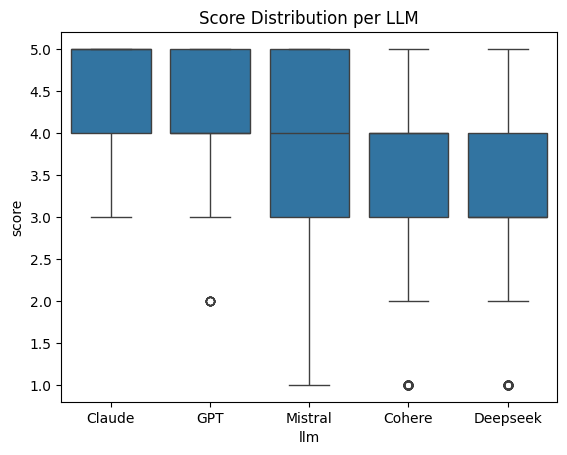

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df, x='llm', y='score')
plt.title('Score Distribution per LLM')
plt.show()

<ipython-input-49-8c1a2cf893af>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='llm', y='score', inner='box', palette=model_palette)


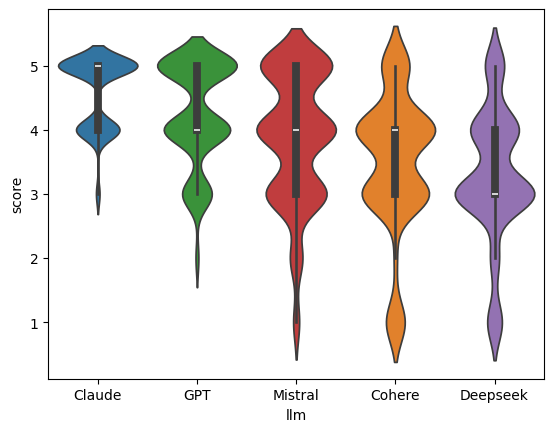

In [ ]:
sns.violinplot(data=df, x='llm', y='score', inner='box', palette=model_palette)
#plt.title('Score Variability per LLM')

plt.savefig("reinforcement_4.png", dpi=300, bbox_inches='tight')

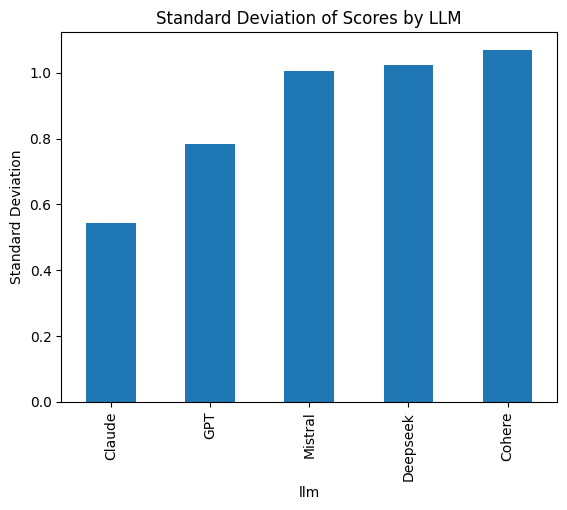

In [ ]:
df.groupby('llm')['score'].std().sort_values().plot(kind='bar', title='Standard Deviation of Scores by LLM')
plt.ylabel('Standard Deviation')
plt.show()


In [ ]:
from scipy.stats import levene

grouped = [group['score'].values for _, group in df.groupby('llm')]
stat, p = levene(*grouped)
print(f"Levene’s test p-value: {p}")


Levene’s test p-value: 2.5496319488767865e-22


In [ ]:
from scipy.stats import f_oneway

stat, p = f_oneway(*grouped)
print(f"ANOVA p-value: {p}")


ANOVA p-value: 6.26968154532699e-134


In [ ]:
consistency_ranking = df.groupby('llm')['score'].std().sort_values()
print(consistency_ranking)


llm
Claude      0.544604
GPT         0.784683
Mistral     1.004477
Deepseek    1.024423
Cohere      1.069527
Name: score, dtype: float64


In [ ]:
def analyze_score_trend_with_ranking(df):
    import pandas as pd
    import statsmodels.api as sm
    from scipy.stats import kendalltau
    import seaborn as sns
    import matplotlib.pyplot as plt

    df = df.copy()

    results = []

    print("======= Linear Regression Results (Score vs Iteration) =======")
    for llm in df['llm'].unique():
        sub = df[df['llm'] == llm].sort_values(by='iteration')
        X = sm.add_constant(sub['iteration'])
        model = sm.OLS(sub['score'], X).fit()
        slope = model.params[1]
        p_value = model.pvalues[1]
        trend = "No change"
        note = "➡️"

        if p_value < 0.05:
            if slope < 0:
                trend = "Degradation"
                note = "📉"
            else:
                trend = "Improvement"
                note = "📈"

        print(f"{llm}: Slope = {slope:.4f}, p = {p_value:.4f} --> {trend} {note}")
        results.append({
            "llm": llm,
            "slope": slope,
            "abs_slope": abs(slope),
            "p_value": p_value,
            "trend": trend
        })
        print("-" * 60)

    print("\n======= Kendall's Tau (Trend Check) =======")
    for llm in df['llm'].unique():
        sub = df[df['llm'] == llm].sort_values(by='iteration')
        tau, p = kendalltau(sub['iteration'], sub['score'])
        print(f"{llm}: Kendall Tau = {tau:.4f}, p = {p:.4f}")
    print("-" * 60)

    # ⬇️ Ranking LLMs by consistency
    print("\n======= LLM Ranking (Most Stable First) =======")
    ranking_df = pd.DataFrame(results)
    ranking_df = ranking_df.sort_values(by=["abs_slope", "p_value"])
    for i, row in ranking_df.iterrows():
        arrow = "✅" if row["trend"] == "No change" else ("⚠️" if row["trend"] == "Degradation" else "⬆️")
        print(f"{row['llm']:10s} | Slope: {row['slope']:+.4f} | Trend: {row['trend']:12s} {arrow}")

    # Plots
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='iteration', y='score', hue='llm', marker='o')
    plt.title('Score over Iterations per LLM')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for llm in df['llm'].unique():
        sub = df[df['llm'] == llm].sort_values(by='iteration')
        sub['rolling'] = sub['score'].rolling(5, center=True).mean()
        plt.plot(sub['iteration'], sub['rolling'], label=llm)
    plt.legend()
    plt.title('Rolling Average Score (5-iteration window)')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()


======= Linear Regression Results (Score vs Iteration) =======
Claude: Slope = -0.0003, p = 0.8557 --> No change ➡️
------------------------------------------------------------
GPT: Slope = 0.0027, p = 0.2744 --> No change ➡️
------------------------------------------------------------
Mistral: Slope = -0.0005, p = 0.8691 --> No change ➡️
------------------------------------------------------------
Cohere: Slope = -0.0030, p = 0.3727 --> No change ➡️
------------------------------------------------------------
Deepseek: Slope = 0.0018, p = 0.5660 --> No change ➡️
------------------------------------------------------------

======= Kendall's Tau (Trend Check) =======
Claude: Kendall Tau = -0.0034, p = 0.9258
GPT: Kendall Tau = 0.0346, p = 0.3226
Mistral: Kendall Tau = 0.0019, p = 0.9552
Cohere: Kendall Tau = -0.0404, p = 0.2377
Deepseek: Kendall Tau = 0.0205, p = 0.5495
------------------------------------------------------------

======= LLM Ranking (Most Stable First) =======
Claude 

<ipython-input-33-5b801b5ec4be>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
<ipython-input-33-5b801b5ec4be>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]
<ipython-input-33-5b801b5ec4be>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
<ipython-input-33-5b801b5ec4be>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In 

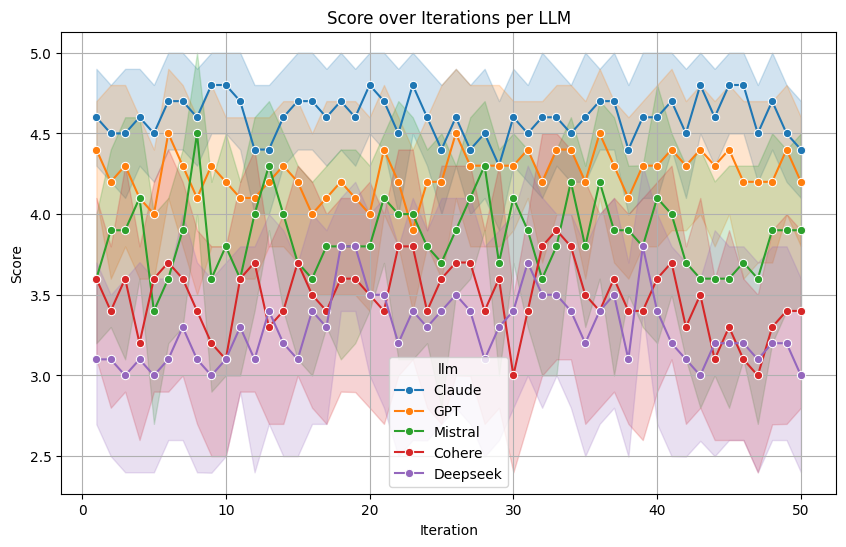

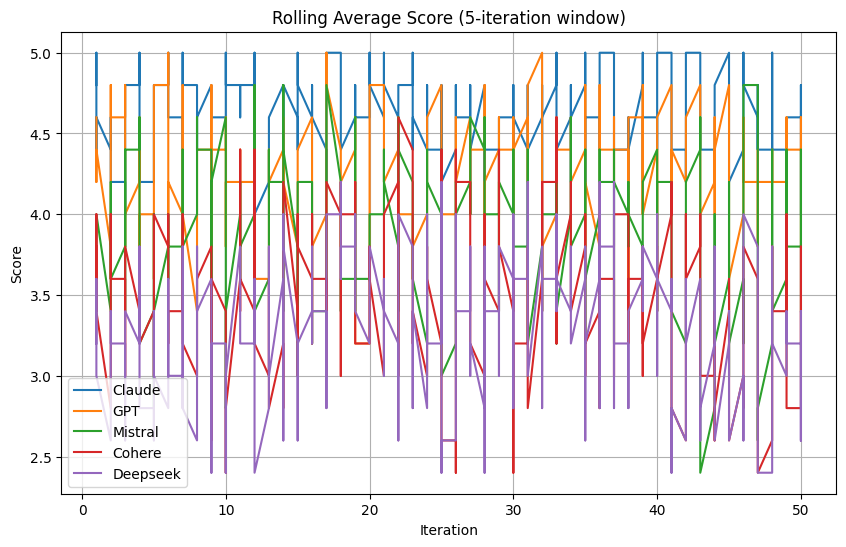

In [ ]:
analyze_score_trend_with_ranking(df)


In [ ]:
def get_llm_score_trend_metrics(df):
    import pandas as pd
    import statsmodels.api as sm
    from scipy.stats import kendalltau

    df = df.copy()


    records = []

    for llm in df['llm'].unique():
        sub = df[df['llm'] == llm].sort_values(by='iteration')
        mean_score = sub['score'].mean()
        std_score = sub['score'].std()

        # Linear Regression
        X = sm.add_constant(sub['iteration'])
        model = sm.OLS(sub['score'], X).fit()
        slope = model.params[1]
        slope_p = model.pvalues[1]

        # Kendall's Tau
        tau, tau_p = kendalltau(sub['iteration'], sub['score'])

        if slope_p < 0.05:
            trend = "Improving" if slope > 0 else "Degrading"
        else:
            trend = "No Change"

        records.append({
            "LLM": llm,
            "Mean Score": round(mean_score, 3),
            "Std Dev": round(std_score, 3),
            "Slope": round(slope, 4),
            "p-value (slope)": round(slope_p, 4),
            "Kendall's Tau": round(tau, 4),
            "p-value (tau)": round(tau_p, 4),
            "Trend": trend
        })

    result_df = pd.DataFrame(records).sort_values(by="Std Dev")
    return result_df


In [ ]:
summary_df = get_llm_score_trend_metrics(df)
display(summary_df)


<ipython-input-37-d9b799ab6e43>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
<ipython-input-37-d9b799ab6e43>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope_p = model.pvalues[1]
<ipython-input-37-d9b799ab6e43>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
<ipython-input-37-d9b799ab6e43>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In 

,LLM,Mean Score,Std Dev,Slope,p-value (slope),Kendall's Tau,p-value (tau),Trend
0,Claude,4.600,0.545,-0.0003,0.8557,-0.0034,0.9258,No Change
1,GPT,4.248,0.785,0.0027,0.2744,0.0346,0.3226,No Change
2,Mistral,3.862,1.004,-0.0005,0.8691,0.0019,0.9552,No Change
4,Deepseek,3.284,1.024,0.0018,0.5660,0.0205,0.5495,No Change
3,Cohere,3.480,1.070,-0.0030,0.3727,-0.0404,0.2377,No Change
